<a href="https://colab.research.google.com/github/marhooo/AKMMH/blob/main/%D0%90%D0%9A%D0%9C%D0%9C%D0%9D_%D0%A4%D0%91_52%D0%BC%D0%BF_%D0%9F%D0%B5%D1%88%D0%BA%D0%BE%D0%B2%D0%B0_%D0%9C%D0%B0%D1%80%D0%B3%D0%B0%D1%80%D0%B8%D1%82%D0%B0_%D0%91%D0%BE%D0%BD%D0%B4%D0%B0%D1%80%D0%B5%D0%BD%D0%BA%D0%BE_%D0%AF%D0%BD%D0%B0_%D0%9F%D1%80_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Аналіз кіберінцидентів методами машинного навчання
Практична робота №7

Тема: Метод до чутливого розташування хешування в системах машинного навчання

Імпорт бібліотек

In [31]:
import numpy as np
import os
import time
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def find_folder_with_classes(base_dir, target_class='buildings'):
    for root, dirs, files in os.walk(base_dir):
        if target_class in dirs:
            return root
    return None

## Векторизація зображень (Feature Extraction)

Перетворення картинок на числа, замість пікселів використовуватимуться гістограми кольорів - це стискає інформацію про зображення у невеликий вектор (48 чисел), що значно пришвидшує роботу LSH.

In [32]:
def get_image_features(image_path, bins=16):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((64, 64)) # Зменшуємо для швидкості читання
        img_arr = np.array(img)
        features = []

        # Рахуємо гістограму для кожного каналу (R, G, B)
        for i in range(3):
            hist, _ = np.histogram(img_arr[:,:,i], bins=bins, range=(0, 256))
            features.extend(hist)

        features = np.array(features, dtype=float)
        # Нормалізація вектора (важливо для коректного порівняння)
        norm = np.linalg.norm(features)
        return features / norm if norm > 0 else features
    except:
        return None

## Завантаження датасету

In [33]:
def load_data(root_path, split_name):
    real_path = find_folder_with_classes(root_path)

    if real_path and split_name not in real_path:
        parent = os.path.dirname(real_path)
        possible_path = os.path.join(parent, split_name)
        if os.path.exists(possible_path) and 'buildings' in os.listdir(possible_path):
            real_path = possible_path
        elif os.path.exists(os.path.join(parent, split_name, split_name)):
             real_path = os.path.join(parent, split_name, split_name)

    if not real_path or not os.path.exists(real_path):
        print(f"Не знайдено папку для {split_name}")
        return [], []

    print(f"Завантаження {split_name} з: {real_path}")

    data, labels = [], []
    classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    class_map = {name: i for i, name in enumerate(classes)}

    for cls in classes:
        cls_folder = os.path.join(real_path, cls)
        if not os.path.exists(cls_folder): continue

        files = os.listdir(cls_folder)[:1500]
        for f in files:
            vec = get_image_features(os.path.join(cls_folder, f))
            if vec is not None:
                data.append(vec)
                labels.append(class_map[cls])

    return np.array(data), np.array(labels)

## Реалізація класу LSH

Клас реалізує метод випадкових проекцій , розбиває простір на кошики (buckets)  та дозволяє швидко знаходити кандидатів на схожість без повного перебору.

In [34]:
class OptimizedLSH:
    def __init__(self, num_hash_functions, input_dim):
        # Генеруємо випадкові гіперплощини для розбиття простору
        self.planes = np.random.randn(input_dim, num_hash_functions)
        self.buckets = {}

    def _hash(self, X):
        # Отримуємо бінарний код (сигнатуру) для вектора
        return (np.dot(X, self.planes) > 0).astype(int)

    def _hash_to_int(self, bits):
        # Перетворюємо бінарний код у ціле число (ID кошика)
        powers = 1 << np.arange(bits.shape[1])[::-1]
        return bits.dot(powers)

    def index(self, X, y):
        """ Індексація: розкладання векторів по кошиках """
        self.buckets = {}
        bits = self._hash(X)
        ids = self._hash_to_int(bits)
        for i, b_id in enumerate(ids):
            if b_id not in self.buckets: self.buckets[b_id] = []
            self.buckets[b_id].append((X[i], y[i]))

    def query(self, x):
        """ Пошук: повертає вміст кошика, куди потрапив запит """
        bits = self._hash(x.reshape(1, -1))
        b_id = self._hash_to_int(bits)[0]
        return self.buckets.get(b_id, [])

## Підготовка даних
Запускаємо процес завантаження. Тут ми отримуємо готові масиви X_train (для навчання) та X_test (для перевірки).

In [35]:
print("Пошук та завантаження даних...")
X_train, y_train = load_data('dataset_intel', 'seg_train')
X_test, y_test = load_data('dataset_intel', 'seg_test')

if len(X_train) > 0:
    print(f"\nДані готові!")
    print(f"Train: {len(X_train)} | Test: {len(X_test)}")
    print(f"Розмірність вектора ознак: {X_train.shape[1]}")
else:
    print("Помилка: Дані не знайдено.")

Пошук та завантаження даних...
Завантаження seg_train з: dataset_intel/seg_train/seg_train
Завантаження seg_test з: dataset_intel/seg_train/seg_train

Дані готові!
Train: 9000 | Test: 9000
Розмірність вектора ознак: 48


## Порівняння алгоритмів
Запустимо LSH та k-NN на одних і тих самих даних, заміряємо час роботи та точність, і виведемо порівняльну таблицю.

In [36]:
if len(X_train) > 0:
    # 1. Експеримент LSH
    # num_hash_functions=12 дає 4096 можливих кошиків (2^12)
    lsh = OptimizedLSH(num_hash_functions=12, input_dim=X_train.shape[1])

    print("\n🚀 LSH: Індексація та тестування...")
    start = time.time()
    lsh.index(X_train, y_train) # Будуємо індекс

    lsh_preds = []
    for x in X_test:
        cands = lsh.query(x)
        if not cands:
            lsh_preds.append(1) # Якщо кошик порожній, ставимо дефолтний клас
        else:
            lbls = [c[1] for c in cands]
            lsh_preds.append(max(set(lbls), key=lbls.count)) # Голосування
    t_lsh_test = time.time() - start
    acc_lsh = accuracy_score(y_test, lsh_preds)

    # 2. Експеримент k-NN (Точний метод)
    print("🐢 k-NN: Навчання та тестування...")
    knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute')

    start = time.time()
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    t_knn_test = time.time() - start
    acc_knn = accuracy_score(y_test, knn_preds)

    # 3. Виведення результатів
    print("\n" + "="*60)
    print(f"{'Metric':<15} | {'LSH (Approx)':<15} | {'k-NN (Exact)':<15}")
    print("-" * 60)
    print(f"{'Accuracy':<15} | {acc_lsh:.4f}          | {acc_knn:.4f}")
    print(f"{'Time (Total)':<15} | {t_lsh_test:.4f}s         | {t_knn_test:.4f}s")
    print("="*60)


🚀 LSH: Індексація та тестування...
🐢 k-NN: Навчання та тестування...

Metric          | LSH (Approx)    | k-NN (Exact)   
------------------------------------------------------------
Accuracy        | 0.4368          | 0.6177
Time (Total)    | 0.5557s         | 0.6510s


## Візуалізація даних

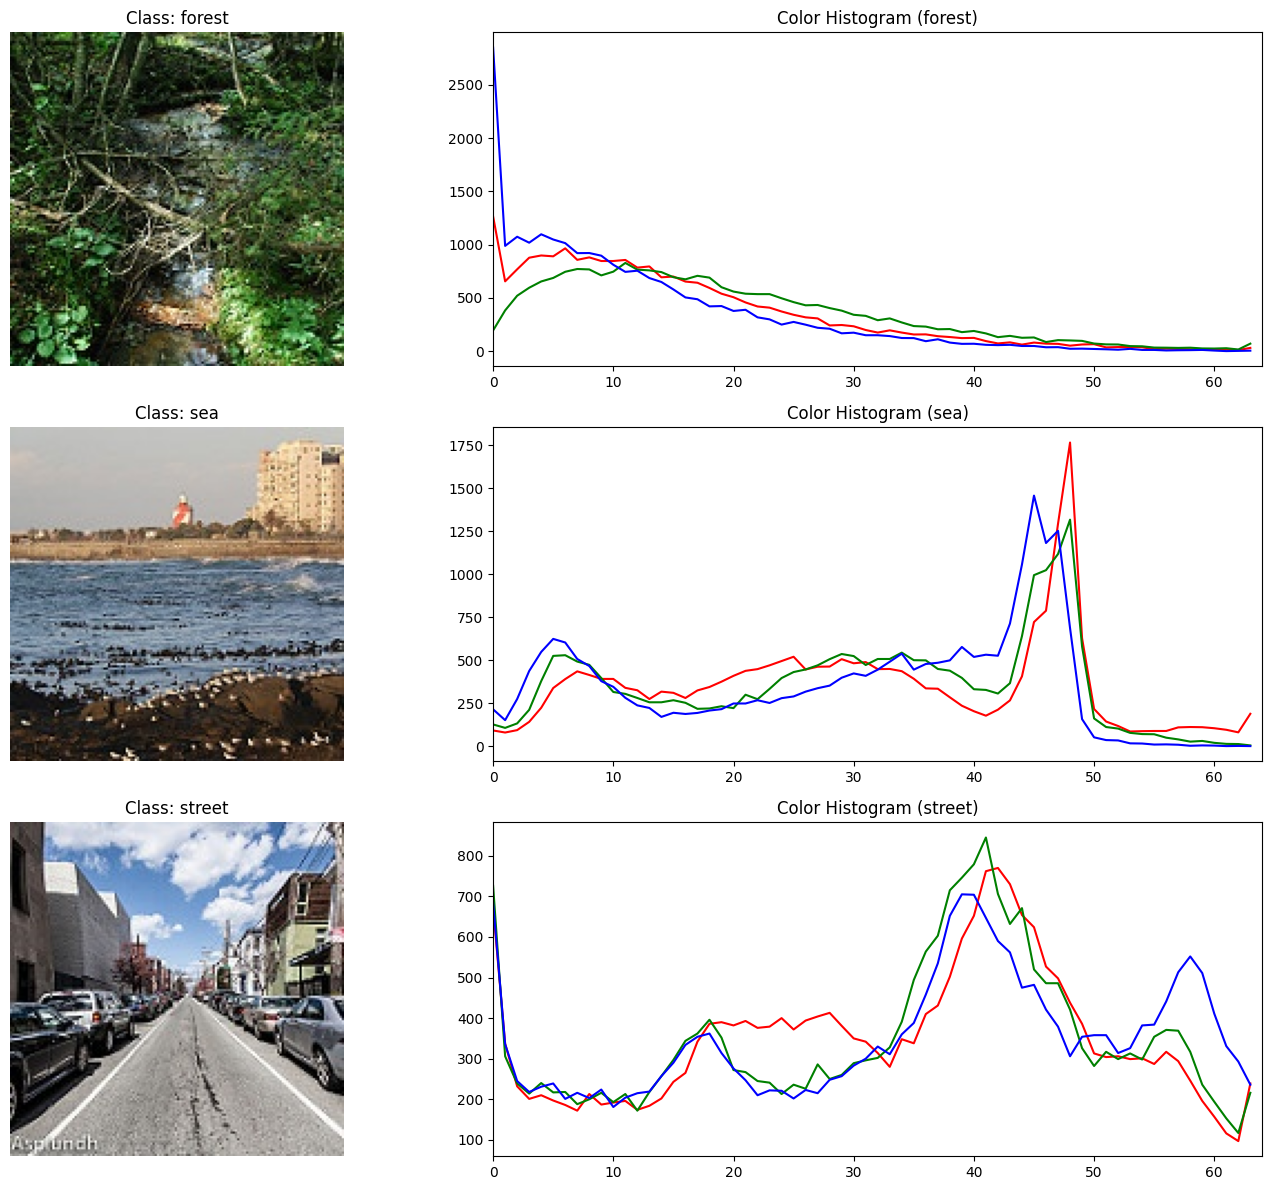

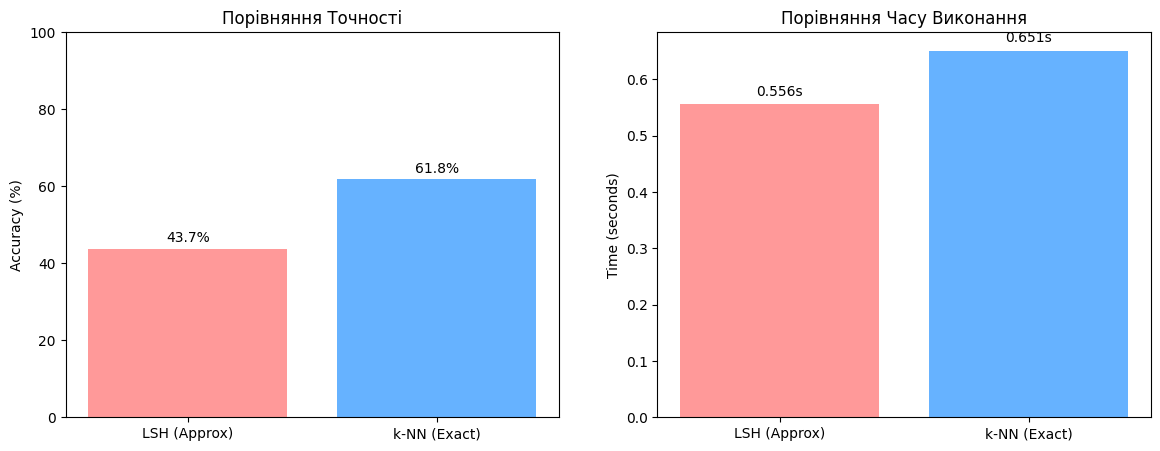

In [37]:
import matplotlib.pyplot as plt
import random

# 1.Візуалізація картинка -> гістограма"
def plot_sample_histograms(base_dir, num_samples=3):
    real_path = find_folder_with_classes(base_dir)
    if not real_path: return

    classes = ['forest', 'sea', 'street']
    plt.figure(figsize=(15, 4 * num_samples))

    for row, cls in enumerate(classes):
        cls_folder = os.path.join(real_path, cls)
        if not os.path.exists(cls_folder): continue

        fname = random.choice(os.listdir(cls_folder))
        img_path = os.path.join(cls_folder, fname)

        # 1. Оригінал
        img = Image.open(img_path).convert('RGB')
        plt.subplot(num_samples, 2, row*2 + 1)
        plt.imshow(img)
        plt.title(f"Class: {cls}")
        plt.axis('off')

        # 2. Гістограма (те, що бачить LSH)
        img_arr = np.array(img)
        colors = ('r', 'g', 'b')
        plt.subplot(num_samples, 2, row*2 + 2)
        plt.title(f"Color Histogram ({cls})")

        for i, color in enumerate(colors):
            hist, bins = np.histogram(img_arr[:,:,i], bins=64, range=(0, 256))
            plt.plot(hist, color=color)
            plt.xlim([0, 64])

    plt.tight_layout()
    plt.show()

# 2. Графіки порівняння результатів

def plot_results(acc_lsh, acc_knn, time_lsh, time_knn):
    labels = ['LSH (Approx)', 'k-NN (Exact)']
    accuracy = [acc_lsh * 100, acc_knn * 100]
    times = [time_lsh, time_knn]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Графік Точності
    bars1 = ax1.bar(labels, accuracy, color=['#FF9999', '#66B2FF'])
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Порівняння Точності')
    ax1.set_ylim(0, 100)

    for bar in bars1:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

    # Графік Часу
    bars2 = ax2.bar(labels, times, color=['#FF9999', '#66B2FF'])
    ax2.set_ylabel('Time (seconds)')
    ax2.set_title('Порівняння Часу Виконання')

    for bar in bars2:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}s', ha='center', va='bottom')

    plt.show()

plot_sample_histograms('dataset_intel')

plot_results(acc_lsh, acc_knn, t_lsh_test, t_knn_test)

## Висновок

У  лабораторній роботі було досліджено метод LSH (Locality Sensitive Hashing), який використовується для швидкого знаходження схожих об'єктів у великих наборах даних шляхом зменшення їх розмірності.

Для класифікації зображень з датасету Intel Image Classification (6 класів: buildings, forest, glacier, mountain, sea, street) було використано метод колірних гістограм. Зображення були перетворені у вектори ознак розмірністю 48, що дозволило ефективно застосувати хешування.

При порівнянні LSH та k-NN експеримент продемонстрував наступні результати. Метод LSH показав меншу точність порівняно з точним методом k-NN. Це узгоджується з теорією, оскільки LSH є наближеним алгоритмом, який об'єднує об'єкти в кошики з певною ймовірністю.

На тестовому наборі (9000 зображень) класичний k-NN виявився конкурентним за часом. Це пояснюється тим, що LSH доцільно використовувати для дуже великих наборів даних або у просторах надвисокої розмірності, де пряме обчислення відстаней стає надто ресурсомістким.

Отже, LSH дозволяє значно економити пам'ять, зберігаючи бітові сигнатури замість повних векторів, проте для задач, де критична точність і обсяг даних помірний (до 50-100 тис.), класичний k-NN залишається кращим вибором.